In [1]:
%load_ext autoreload
%autoreload 2

In [63]:
import pymc as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns

In [80]:
def build_simple_model(df, stat='PTS', season=None):
    """
    Basic hierarchical model:
    
    For each game i:
    y[i] = baseline[team[i]] + home_effect * is_home[i] + rest_effect[rest[i]] + ε
    
    Where:
    - baseline[team] ~ Normal(league_mean, σ_team)
    - home_effect ~ Normal(0, 5)        # weakly informative
    - rest_effect[k] ~ Normal(0, 5)     # one for each rest category
    - ε ~ Normal(0, σ_y)
    - σ_y ~ HalfNormal(10)
    """
    
    # Prepare data
    if season is not None:
        data = df[df['SEASON'] == season].copy()
    else:
        data = df.copy()
    
    # Get unique teams and calculate overall mean
    teams = data['TEAM'].unique()
    n_teams = len(teams)
    team_indices = pd.Categorical(data['TEAM'], categories=teams).codes
    
    league_mean = data[stat].mean()
    league_std = data[stat].std()
    
    # Rest categories
    rest_categories = sorted(data['REST'].unique())
    n_rest_cats = len(rest_categories)
    rest_indices = pd.Categorical(data['REST'], categories=rest_categories).codes
    
    with pm.Model() as model:
        # Hyperpriors
        σ_team = pm.HalfNormal('σ_team', sigma=10)
        σ_y = pm.HalfNormal('σ_y', sigma=10)
        
        # Team baselines
        baseline = pm.Normal('baseline', 
                           mu=league_mean, 
                           sigma=σ_team,
                           shape=n_teams)
        
        # Home court effect (league-wide)
        home_effect = pm.Normal('home_effect', 
                              mu=2.5, 
                              sigma=2.5)
        
        # Rest effects
        rest_effects = pm.Normal('rest_effects',
                               mu=0,
                               sigma=2.5,
                               shape=n_rest_cats)
        
        # Expected value
        μ = (baseline[team_indices] + 
             home_effect * data['IS_HOME'] +
             rest_effects[rest_indices])
        
        # Likelihood
        y = pm.Normal('y',
                     mu=μ,
                     sigma=σ_y,
                     observed=data[stat])
        
    return model, data

def fit_simple_model(model, draws=2000, chains=4):
    """
    Fit the model using NUTS sampler
    """
    with model:
        # Find good starting values
        start = pm.find_MAP()
        
        # Sample
        trace = pm.sample(draws=draws,
                         chains=chains,
                         tune=1000,
                         return_inferencedata=True,
                         target_accept=0.95)
    
    return trace

def analyze_simple_model(trace, data, stat='PTS'):
    """
    Analyze results of the simple model
    """
    print("\nTeam Baselines:")
    teams = data['TEAM'].unique()
    team_baselines = trace.posterior['baseline'].mean(dim=('chain', 'draw'))
    team_baselines_sd = trace.posterior['baseline'].std(dim=('chain', 'draw'))
    
    team_effects = pd.DataFrame({
        'Team': teams,
        'Baseline': team_baselines,
        'SD': team_baselines_sd
    })
    team_effects = team_effects.sort_values('Baseline', ascending=False)
    
    print("\nTeam Offensive Levels (sorted):")
    for _, row in team_effects.iterrows():
        print(f"{row['Team']}: {row['Baseline']:.1f} ± {row['SD']:.1f}")
    
    # Visualize team baselines
    plt.figure(figsize=(12, 6))
    plt.errorbar(range(len(teams)), 
                team_effects['Baseline'],
                yerr=team_effects['SD'],
                fmt='o')
    plt.xticks(range(len(teams)), 
               team_effects['Team'],
               rotation=45,
               ha='right')
    plt.axhline(y=data[stat].mean(), 
                color='r', 
                linestyle='--', 
                label='League Average')
    plt.title('Team Baseline Values with Uncertainty')
    plt.ylabel(f'{stat} Baseline')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Print basic parameter estimates
    print("\n=== Model Parameters ===")
    print("\nHome Court Effect:")
    print(f"Mean: {trace.posterior['home_effect'].mean().item():.2f}")
    print(f"SD: {trace.posterior['home_effect'].std().item():.2f}")
    print(f"95% CI: [{np.percentile(trace.posterior['home_effect'], 2.5):.2f}, "
          f"{np.percentile(trace.posterior['home_effect'], 97.5):.2f}]")
    
    print("\nRest Effects:")
    rest_effects = trace.posterior['rest_effects'].mean(dim=('chain', 'draw'))
    rest_effects_sd = trace.posterior['rest_effects'].std(dim=('chain', 'draw'))
    
    for i, (effect, sd) in enumerate(zip(rest_effects, rest_effects_sd)):
        print(f"Rest {i}:")
        print(f"Mean: {effect:.2f}")
        print(f"SD: {sd:.2f}")
    
    # Parameter plots
    az.plot_forest(trace, var_names=['home_effect', 'rest_effects'])
    plt.title('Parameter Estimates with 95% CI')
    plt.show()
    
    # Trace plots
    az.plot_trace(trace, var_names=['home_effect', 'rest_effects'])
    plt.show()
    
    # Posterior predictive check
    with model:
        ppc = pm.sample_posterior_predictive(
            trace,
            return_inferencedata=True,  # This is key!
            extend_inferencedata=True
        )
    
    # Plot posterior predictive distribution vs actual data
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot actual data distribution
    sns.histplot(data=data['PTS'], 
                label='Actual',
                stat='density',
                alpha=0.5,
                ax=ax)
    
    # Plot predicted data distributions
    ppc_samples = ppc.posterior_predictive.y.values.flatten()
    sns.histplot(data=ppc_samples,
                label='Predicted',
                stat='density',
                alpha=0.5,
                ax=ax)
    
    plt.title('Posterior Predictive Check')
    plt.legend()
    plt.show()
    
    # Calculate and plot residuals
    predicted_mean = ppc.posterior_predictive.y.mean(dim=('chain', 'draw'))
    residuals = data[stat] - predicted_mean
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Residual plot
    ax1.scatter(predicted_mean, residuals, alpha=0.5)
    ax1.axhline(y=0, color='r', linestyle='--')
    ax1.set_xlabel('Predicted Values')
    ax1.set_ylabel('Residuals')
    ax1.set_title('Residual Plot')
    
    # QQ plot
    from scipy import stats
    stats.probplot(residuals, dist="norm", plot=ax2)
    ax2.set_title('Normal Q-Q Plot of Residuals')
    
    plt.tight_layout()
    plt.show()
    
    # Print predictive accuracy metrics
    rmse = np.sqrt(np.mean((predicted_mean - data['PTS'])**2))
    mae = np.mean(np.abs(predicted_mean - data['PTS']))
    print("\n=== Predictive Accuracy ===")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    
    return ppc

Output()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ_team, σ_y, baseline, home_effect, rest_effects]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 8 seconds.



Team Baselines:

Team Offensive Levels (sorted):
BUC: 117.1 ± 1.4
WAR: 116.7 ± 1.4
PEL: 114.7 ± 1.4
76E: 114.4 ± 1.4
CLI: 114.4 ± 1.4
BLA: 114.0 ± 1.4
THU: 113.8 ± 1.4
RAP: 113.8 ± 1.4
KIN: 113.6 ± 1.4
WIZ: 113.5 ± 1.4
ROC: 113.3 ± 1.4
HAW: 112.8 ± 1.4
TIM: 112.0 ± 1.4
CEL: 112.0 ± 1.4
NET: 111.8 ± 1.4
LAK: 111.4 ± 1.4
JAZ: 111.4 ± 1.4
SPU: 111.3 ± 1.4
HOR: 110.5 ± 1.4
NUG: 110.4 ± 1.4
MAV: 108.8 ± 1.5
PAC: 108.0 ± 1.4
SUN: 107.6 ± 1.4
MAG: 107.4 ± 1.4
PIS: 107.2 ± 1.4
HEA: 106.0 ± 1.4
BUL: 105.3 ± 1.4
KNI: 104.9 ± 1.4
CAV: 104.9 ± 1.4
GRI: 104.0 ± 1.4


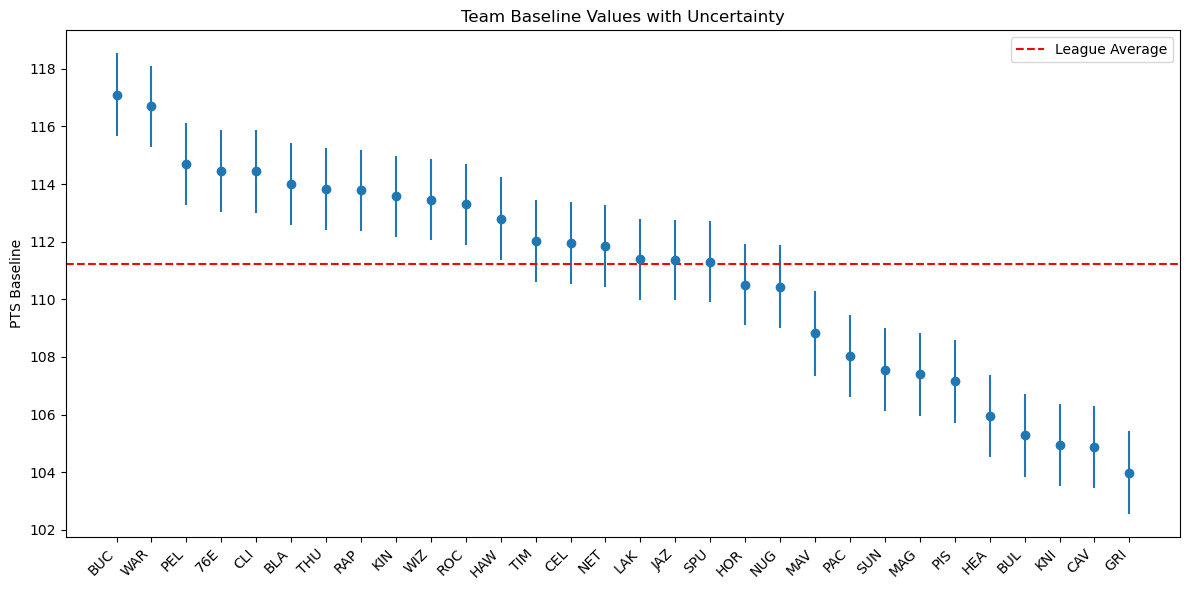


=== Model Parameters ===

Home Court Effect:
Mean: 2.57
SD: 0.48
95% CI: [1.63, 3.52]

Rest Effects:
Rest 0:
Mean: -0.56
SD: 0.86
Rest 1:
Mean: -2.01
SD: 0.90
Rest 2:
Mean: -0.81
SD: 0.78


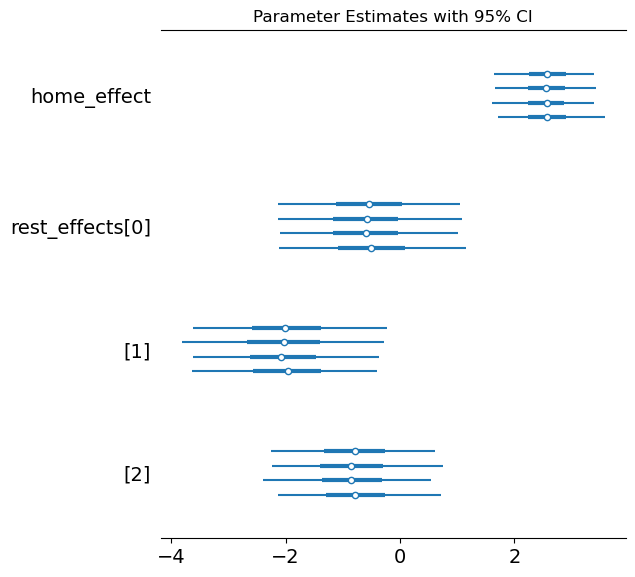

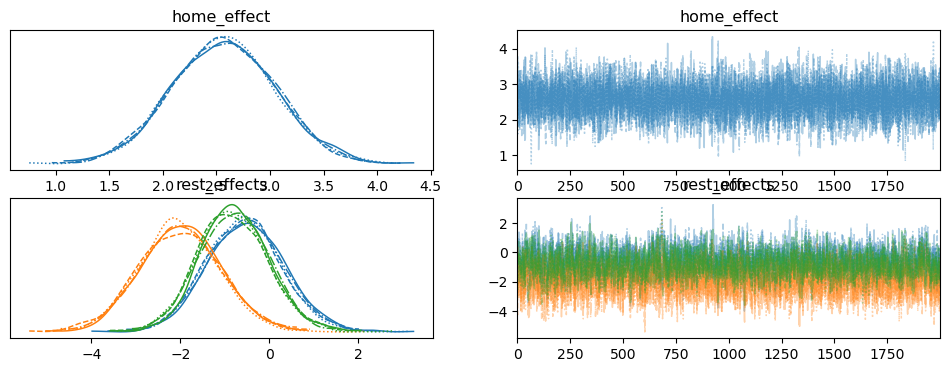

Sampling: [y]


Output()

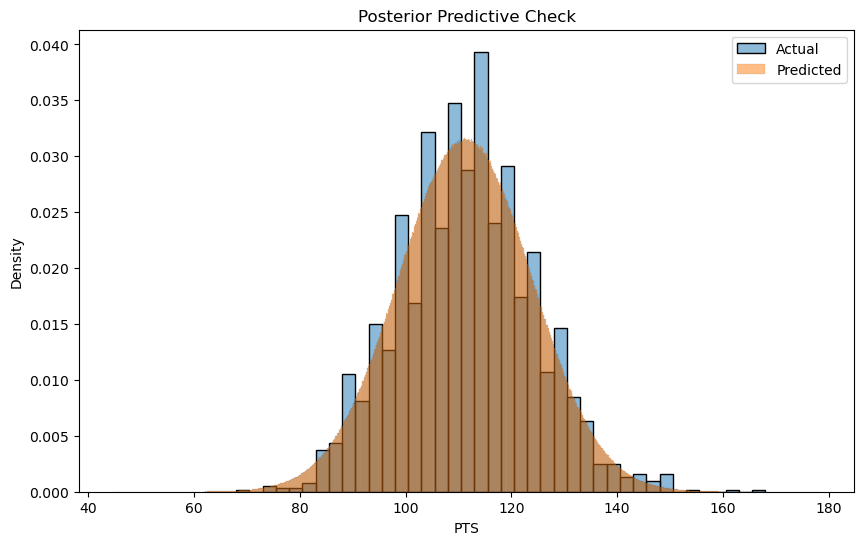

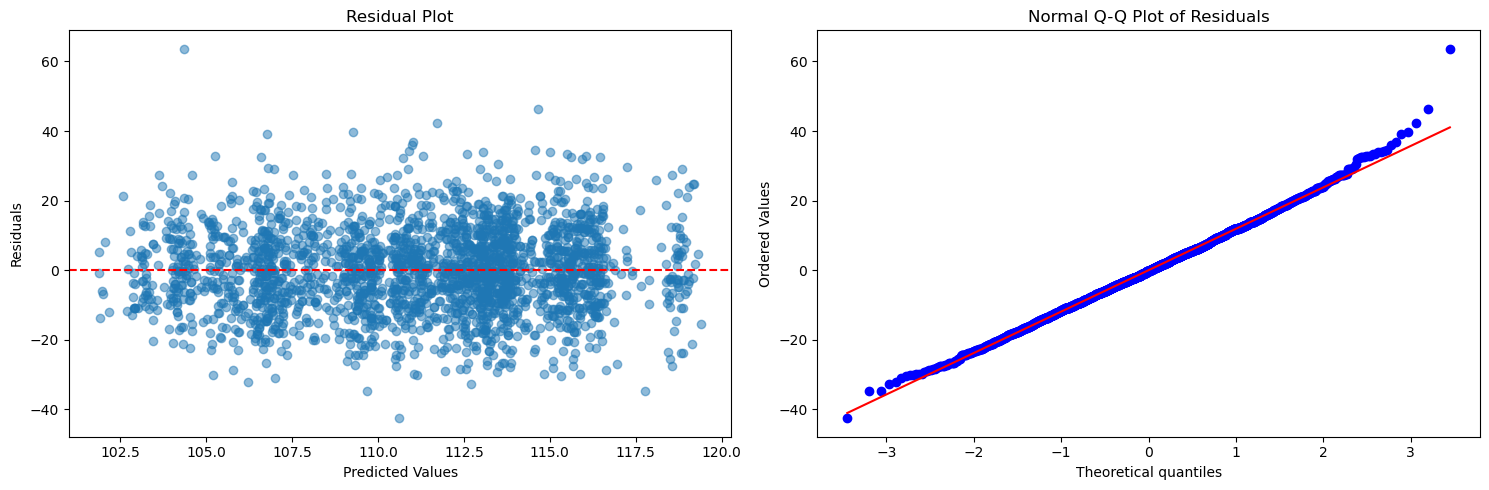


=== Predictive Accuracy ===
RMSE: 11.91
MAE: 9.42


In [81]:
df = pd.read_csv('data/game/box_raw/reshaped_regular_season_games.csv')
model, data = build_simple_model(df, stat='PTS', season='2018-19')
trace = fit_simple_model(model)
ppc = analyze_simple_model(trace, data)